# ABOUT

This notebook demonstrates the analysis of the _in silico_ data as described in the paper. The data is available for download [here](https://resources.drcmr.dk/MAPdata/susceptibility-and-axon-morphology-dataset/).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Make GPU visible. Must be done before torch is imported.
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #index of gpu of interest

# import
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pickle

import warnings
warnings.filterwarnings("ignore")

In [3]:
torch.set_default_dtype(torch.float64)

# DEVICE

Check available devices. Choose GPU if one is available. Else choose cpu.

In [4]:
torch.cuda.is_available()

False

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

torch.device(device)

print(f'number of devices: {torch.cuda.device_count()}')
print(f'device: {device}')

number of devices: 0
device: cpu


### <font color='orange'>NB</font>

If trying to load .signal files from [https://resources.drcmr.dk/MAPdata/susceptibility-and-axon-morphology-dataset/](https://resources.drcmr.dk/MAPdata/susceptibility-and-axon-morphology-dataset/) on a computer without a GPU which is not compatible with torch, the following will be necessary to load the files:

- Go to .venv/lib/python3.10/site-packages/torch/storage.py:530
- Add map_location=torch.device('cpu') as an argument.

Unfortunatly, setting torch.device() in the notebook does not take effect for this.

# PLOTTING SPECS

In [7]:
size_font = 11

plt.rc('font', family='serif')
plt.rc('font', size=size_font)        # controls default text sizes
plt.rc('axes', titlesize=size_font)   # fontsize of the axes title
plt.rc('axes', labelsize=size_font)   # fontsize of the x and y labels
plt.rc('xtick', labelsize=size_font)  # fontsize of the tick labels
plt.rc('ytick', labelsize=size_font)  # fontsize of the tick labels
plt.rc('legend', fontsize=size_font)  # legend fontsize
plt.rc('figure', titlesize=size_font) # fontsize of the figure title

plt.rcParams['figure.dpi'] = 400

In [8]:
figsize_ADC_3x1 = (7.5, 3)
figsize_e1_1x1 = (2.5, 3)

lw = 2
s = 36

marker_intra = 'o'
marker_extra = 'x'
marker_intra_extra = 's'

In [9]:
plotting_specs = {}

plotting_specs['G1-z_aligned'] = {}
plotting_specs['G1-z_aligned']['marker'] = 'o'
plotting_specs['G1-z_aligned']['color'] = 'tab:olive'

plotting_specs['G3-z_aligned'] = {}
plotting_specs['G3-z_aligned']['marker'] = 'o'
plotting_specs['G3-z_aligned']['color'] = 'tab:green'

plotting_specs['G4-z_aligned'] = {}
plotting_specs['G4-z_aligned']['marker'] = 'o'
plotting_specs['G4-z_aligned']['color'] = 'tab:cyan'

plotting_specs['G5-z_aligned'] = {}
plotting_specs['G5-z_aligned']['marker'] = 'o'
plotting_specs['G5-z_aligned']['color'] = 'tab:blue'

plotting_specs['G6-z_aligned'] = {}
plotting_specs['G6-z_aligned']['marker'] = 'o'
plotting_specs['G6-z_aligned']['color'] = 'tab:purple'

# PATHS

In [10]:
path_home = '../'

path_resources = os.path.join(path_home, 'resources')
path_data = os.path.join(path_home, 'data', 'in_silico')
path_substrates = os.path.join(path_data, 'substrates')
path_MCDC = os.path.join(path_data, 'MCDC')
path_figures = os.path.join(path_home, 'figures')

types_substrates = ['G1-z_aligned', 'G3-z_aligned', 'G4-z_aligned', 'G5-z_aligned', 'G6-z_aligned']

# SRC

In [11]:
def get_angles_between_vectors(vecs, vec, symmetry_around_90=False):

    dot = np.sum(vecs*vec, axis=-1)

    radians = np.arccos(dot / (np.linalg.norm(vecs, axis=-1) * np.linalg.norm(vec)))

    angles = radians * 180. / np.pi

    if symmetry_around_90:
        angles[angles > 90.] = 180. - angles[angles > 90.]

    return angles

# LOAD SIGNALS

In [12]:
tag_signal = 'delta=0.0072-Delta=0.0202-max_iter_rough=50000-max_iter_fine=15000'

In [13]:
signals_per_substrate_type = {}

for type_substrate in types_substrates:
    
    print('type_substrate:', type_substrate)
    
    signals_per_substrate_type[type_substrate] = {}
    
    path_signals = os.path.join(path_MCDC, type_substrate)
    
    print('path_signals:', path_signals)
    
    names_substrates_unique = np.unique([n.split('-inner')[0].split('-outer')[0] for n in os.listdir(path_signals) if (tag_signal in n)])
    
    for name_substrate in names_substrates_unique:

        signals_per_substrate_type[type_substrate][name_substrate] = {}

        paths_signals = [os.path.join(path_signals, n) for n in os.listdir(path_signals) if (tag_signal in n) and (name_substrate in n)]
        
        if 'synchrotron' in type_substrate:
            assert len(paths_signals) == 1
        elif 'helix' in type_substrate:
            assert len(paths_signals) == 2
        
        for path_signal in paths_signals:
            
            with open(path_signal, 'rb') as file:
                signals = pickle.load(file)

            path_scheme_file_original = signals['path_scheme_file']

            name_scheme_file = path_scheme_file_original.split('/')[-1]
            path_scheme_file = os.path.join(path_resources, 'DWI', 'schemes', name_scheme_file)
            
            if path_scheme_file not in signals_per_substrate_type[type_substrate][name_substrate].keys():
                signals_per_substrate_type[type_substrate][name_substrate][path_scheme_file] = {}
            
            if 'inner' in path_signal:
                signals_per_substrate_type[type_substrate][name_substrate][path_scheme_file]['intra'] = signals
            elif 'outer' in path_signal:
                signals_per_substrate_type[type_substrate][name_substrate][path_scheme_file]['extra'] = signals

type_substrate: G1-z_aligned
path_signals: ../data/in_silico/MCDC/G1-z_aligned
type_substrate: G3-z_aligned
path_signals: ../data/in_silico/MCDC/G3-z_aligned
type_substrate: G4-z_aligned
path_signals: ../data/in_silico/MCDC/G4-z_aligned
type_substrate: G5-z_aligned
path_signals: ../data/in_silico/MCDC/G5-z_aligned
type_substrate: G6-z_aligned
path_signals: ../data/in_silico/MCDC/G6-z_aligned


### COMPUTE b-VALUES

In [14]:
scheme = np.loadtxt(path_scheme_file, skiprows=1)

small_delta = scheme[1, 5]
big_delta = scheme[1, 4]
b_vectors = scheme[:, :3]
Gs = scheme[:, 3]
gamma = 267.513 * 10**6 # [rad/(sT)] # gyromagnetic ratio for Hydrogen # 42.58 * 10**6 [Hz/T]
b_values = (gamma * Gs * small_delta)**2 * (big_delta - small_delta/3) * 1e-6
b_values_unique = np.unique(b_values)

### COMBINE COMPARTMENTS: INTRA+EXTRA

In [15]:
for type_substrate, per_name_substrate in tqdm(signals_per_substrate_type.items()):
    
    for name_substrate, per_scheme in tqdm(per_name_substrate.items()):
        
        for scheme, per_compartment in per_scheme.items():
            
            # if both an intra and an extra compartment exists, compute signal for the combined compartments
            if ('intra' in per_compartment.keys()) and ('extra' in per_compartment.keys()):
                
                per_compartment['intra+extra'] = {}
                
                per_compartment['intra+extra']['only_diffusion_gradients'] = per_compartment['intra']['only_diffusion_gradients'] + per_compartment['extra']['only_diffusion_gradients']
                
                per_compartment['intra+extra']['only_susceptibility_gradients'] = {k: per_compartment['intra']['only_susceptibility_gradients'][k] + per_compartment['extra']['only_susceptibility_gradients'][k] for k in per_compartment['intra']['only_susceptibility_gradients'].keys()}
                per_compartment['intra+extra']['all_gradients'] = {k: per_compartment['intra']['all_gradients'][k] + per_compartment['extra']['all_gradients'][k] for k in per_compartment['intra']['all_gradients'].keys()}

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

### COMBINE SUBSTRATES: ALL AXONS

In [16]:
for type_substrate, per_name_substrate in tqdm(signals_per_substrate_type.items()):
    
    signals_per_substrate_type[type_substrate]['all'] = {}
    
    for name_substrate, per_scheme in tqdm(per_name_substrate.items()):
        
        for scheme, per_compartment in per_scheme.items():
            
            if scheme not in signals_per_substrate_type[type_substrate]['all']: 
                signals_per_substrate_type[type_substrate]['all'][scheme] = {}
            
            for compartment, per_contribution in per_compartment.items():
                
                if compartment == 'path_scheme_file':
                    continue
                
                if compartment not in signals_per_substrate_type[type_substrate]['all'][scheme]: 
                    signals_per_substrate_type[type_substrate]['all'][scheme][compartment] = {}
                
                for contribution, per_Bfield in per_contribution.items():
                    
                    if contribution == 'only_diffusion_gradients':
                        
                        if contribution not in signals_per_substrate_type[type_substrate]['all'][scheme][compartment]: 
                            signals_per_substrate_type[type_substrate]['all'][scheme][compartment][contribution] = signals_per_substrate_type[type_substrate][name_substrate][scheme][compartment][contribution].clone().detach()
                        else:
                            signals_per_substrate_type[type_substrate]['all'][scheme][compartment][contribution] += signals_per_substrate_type[type_substrate][name_substrate][scheme][compartment][contribution]
                        
                        continue
                    
                    if contribution == 'path_scheme_file':
                        continue
                        
                    else:
                        if contribution not in signals_per_substrate_type[type_substrate]['all'][scheme][compartment]:
                            signals_per_substrate_type[type_substrate]['all'][scheme][compartment][contribution] = {}

                        for Bfield, signals in per_Bfield.items():
                            
                            tag_Bfield = '-'.join(Bfield.split('-')[-2:])

                            if tag_Bfield not in signals_per_substrate_type[type_substrate]['all'][scheme][compartment][contribution]: 
                                signals_per_substrate_type[type_substrate]['all'][scheme][compartment][contribution][tag_Bfield] = signals_per_substrate_type[type_substrate][name_substrate][scheme][compartment][contribution][Bfield].clone().detach()
                            else:
                                signals_per_substrate_type[type_substrate]['all'][scheme][compartment][contribution][tag_Bfield] += signals_per_substrate_type[type_substrate][name_substrate][scheme][compartment][contribution][Bfield]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

# SE SIGNAL

  0%|          | 0/5 [00:00<?, ?it/s]

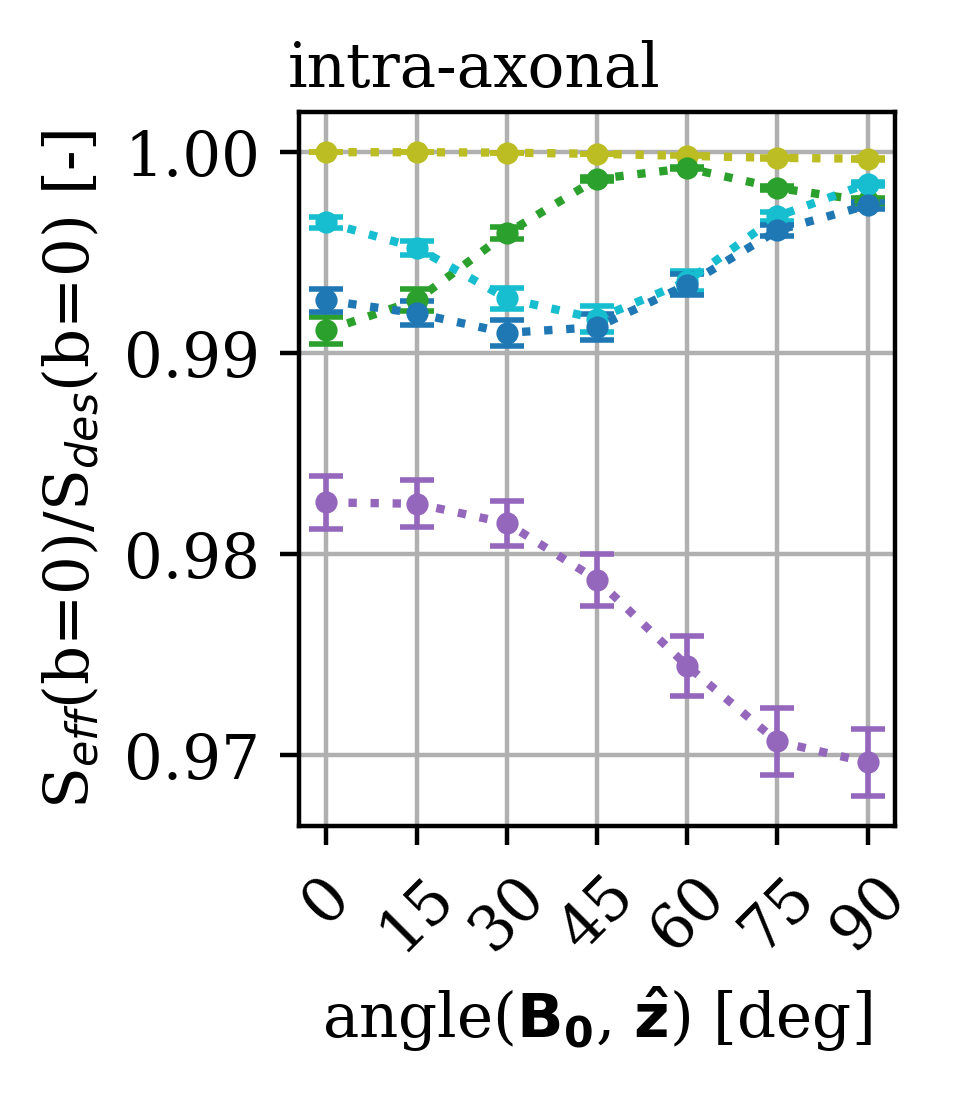

In [19]:
cmap = plt.cm.get_cmap('gnuplot2')

axs_all = []
figs = []

if 'intra' in per_name_substrate[next(iter(per_name_substrate.keys()))][path_scheme_file].keys():
    fig_intra, ax_intra = plt.subplots(1, 1, figsize=figsize_e1_1x1)
    axs_all.append(ax_intra)
    figs.append(fig_intra)
    fig_intra.suptitle('intra-axonal', y=0.9)

if 'extra' in per_name_substrate[next(iter(per_name_substrate.keys()))][path_scheme_file].keys():
    fig_extra, ax_extra = plt.subplots(1, 1, figsize=figsize_e1_1x1)
    axs_all.append(ax_extra)
    figs.append(fig_extra)
    fig_extra.suptitle('extra-axonal', y=0.9)

if 'intra+extra' in per_name_substrate[next(iter(per_name_substrate.keys()))][path_scheme_file].keys():
    fig_intra_extra, ax_intra_extra = plt.subplots(1, 1, figsize=figsize_e1_1x1)
    axs_all.append(ax_intra_extra)
    figs.append(fig_intra_extra)
    fig_intra_extra.suptitle('intra- and extra-axonal', y=0.9)    

for type_substrate, per_name_substrate in tqdm(signals_per_substrate_type.items()):
    
    if len(per_name_substrate.keys()) == 0:
        continue
        
    S0s = []
    B_z_angles = []
    
    S0s_nf = []
    
    for idx_substrate, (name_substrate, per_scheme) in enumerate(per_name_substrate.items()):
        
        if name_substrate == 'all':
            continue
        
        for scheme, per_compartment in per_scheme.items():
            
            for compartment, per_contribution in per_compartment.items():
                
                if compartment == 'intra':
                    fig = fig_intra
                    axs = ax_intra
                    marker = marker_intra
                elif compartment == 'extra':
                    fig = fig_extra
                    axs = ax_extra
                    marker = marker_extra
                if compartment == 'intra+extra':
                    fig = fig_intra_extra
                    axs = ax_intra_extra
                    marker = marker_intra_extra
                    
                #### coloring
                if 'helix' in name_substrate:
                    weight_color = float(name_substrate.split('r_helix=')[-1].split('-')[0]) / 8.
                    color = cmap(weight_color)
                else:
                    color = plotting_specs[type_substrate]['color']
        
                S0_nf = per_contribution['only_diffusion_gradients'][b_values == 0.0].cpu().item()
                
                normalizer = S0_nf
                
                S0s_nf.append(S0_nf/normalizer)
                
                label_switch = True
            
                #### plot including susceptibility contributions
                for name_Bfield, fit_dt in per_contribution['all_gradients'].items():
                    
                    if label_switch:
                        if 'helix' in name_substrate:
                            r_helix = name_substrate.split('r_helix=')[-1].split('-')[0]
                            label = 'r$_{helix}$' + f' = {r_helix}'
                        elif 'axon' in name_substrate:
                            label = name_substrate.split('-')[0]
                        label_switch = False
                    else:
                        label = None
                    
                    S0 = per_contribution['all_gradients'][name_Bfield][b_values == 0.0].cpu().item()
                    S0s.append(S0/normalizer)
                    
                    B_z_angle = int(np.round(np.rad2deg(float(name_Bfield.split('B_z_angle=')[-1].replace('.pt', '')))))
                    B_z_angles.append(B_z_angle)
            
    capsize = 3
    elinewidth = 1
    markeredgewidth = 1
    ls_err = ':'
    marker_err = '.'
    
    n_Bfields = 7
    n_axons = len(S0s)//7
    
    #### S0s
    S0s = np.reshape(S0s, (n_axons, 7))
    S0s_mean = np.mean(S0s, axis=0)
    S0s_err = np.std(S0s, axis=0) / np.sqrt(n_axons)

    axs.errorbar(B_z_angles[:n_Bfields], S0s_mean, yerr=S0s_err, color=color, capsize=capsize, elinewidth=elinewidth, markeredgewidth=markeredgewidth, ls=ls_err, marker=marker_err)
    
    S0s_mean_nf = np.mean(S0s_nf, axis=0)
    S0s_err_nf = np.std(S0s_nf, axis=0) / np.sqrt(n_axons)
    axs.fill_between([0, 90], S0s_mean_nf-S0s_err_nf, S0s_mean_nf+S0s_err_nf, color=color, 
                        alpha=0.5, ec=None, label=type_substrate.split('-')[1]+f', n={n_axons}')

for axs in axs_all:
    
    axs.set_ylim(0.9665, 1.002)
    
    axs.set_ylabel('S$_{eff}$(b=0)/S$_{des}$(b=0) [-]')

    axs.grid(True)
    axs.set_xticks(np.arange(0, 91, 15))
    axs.set_xticklabels(np.arange(0, 91, 15), rotation=45)
    axs.set_xlabel(r'angle($\mathbf{B_0}$, $\mathbf{\hat{z}}$) [deg]')

for fig in figs:

    fig.tight_layout()


path_figure = path_figures + f'/orientation_dependencies/XNH-T2'
plt.savefig(path_figure, dpi=400)

# TENSOR MODELING

### FITTING

In [20]:
import dipy.reconst.dti as dti
import dipy.data

def fit_DTI(volume, bvals, bvecs, big_delta, small_delta, bs_oi, min_signal=None):

    b0_threshold = np.min(bs_oi) + 500

    mask_b = np.zeros(bvals.shape).astype(bool)

    for b_oi in bs_oi:
        mask_b = mask_b + (bvals > b_oi-500) * (bvals < b_oi+500)

    gtab = dipy.data.gradient_table(bvals[mask_b], bvecs=bvecs[mask_b, :],
                                    big_delta=big_delta, small_delta=small_delta,
                                    b0_threshold=b0_threshold)


    #### Instantiate the Tensor model
    tenmodel = dti.TensorModel(gtab, return_S0_hat=True, min_signal=min_signal)

    #### Fit the data
    tenfit = tenmodel.fit(volume[:, :, :, mask_b])
    
    return tenfit

In [21]:
bs_oi = [50, 1000, 3000, 4000]
# bs_oi = [4000, 8000, 12000]
# bs_oi = [8000, 12000, 20000]

In [22]:
tensorfits_per_substrate_type = {}

for type_substrate in signals_per_substrate_type.keys():
    
    tensorfits_per_substrate_type[type_substrate] = {}
    
    for name_substrate in signals_per_substrate_type[type_substrate].keys():
        
        tensorfits_per_substrate_type[type_substrate][name_substrate] = {}
        
        for path_scheme_file in signals_per_substrate_type[type_substrate][name_substrate].keys():
            
            tensorfits_per_substrate_type[type_substrate][name_substrate][path_scheme_file] = {}
            
            scheme = np.loadtxt(path_scheme_file, skiprows=1)
            
            small_delta = scheme[1, 5]
            big_delta = scheme[1, 4]
            b_vectors = scheme[:, :3]
            Gs = scheme[:, 3]
            gamma = 267.513 * 10**6 # [rad/(sT)] # gyromagnetic ratio for Hydrogen # 42.58 * 10**6 [Hz/T]
            b_values = (gamma * Gs * small_delta)**2 * (big_delta - small_delta/3)
            b_values = b_values * 1e-6
        
            for compartment in signals_per_substrate_type[type_substrate][name_substrate][path_scheme_file].keys():
                
                tensorfits_per_substrate_type[type_substrate][name_substrate][path_scheme_file][compartment] = {}
                
                tensorfits_per_substrate_type[type_substrate][name_substrate][path_scheme_file][compartment]['signals_only_diffusion_gradients'] = {}
                tensorfits_per_substrate_type[type_substrate][name_substrate][path_scheme_file][compartment]['signals_only_susceptibility_gradients'] = {}
                tensorfits_per_substrate_type[type_substrate][name_substrate][path_scheme_file][compartment]['signals_all_gradients'] = {}
                
                # no background field
                signals_only_diffusion_gradients = signals_per_substrate_type[type_substrate][name_substrate][path_scheme_file][compartment]['only_diffusion_gradients'].cpu().numpy()
                signals_only_diffusion_gradients /= signals_only_diffusion_gradients[b_values == 0]
                
                fit = fit_DTI(signals_only_diffusion_gradients.reshape((1, 1, 1, signals_only_diffusion_gradients.shape[0])), 
                              b_values, b_vectors, big_delta, small_delta, 
                              bs_oi, min_signal=None)

                tensorfits_per_substrate_type[type_substrate][name_substrate][path_scheme_file][compartment]['signals_only_diffusion_gradients'] = fit
                
                # with background fields
                for path_Bfield in signals_per_substrate_type[type_substrate][name_substrate][path_scheme_file][compartment]['only_susceptibility_gradients'].keys():
                    
                    signals_only_susceptibility_gradients = signals_per_substrate_type[type_substrate][name_substrate][path_scheme_file][compartment]['only_susceptibility_gradients'][path_Bfield].cpu().numpy()
                    signals_only_susceptibility_gradients /= signals_only_susceptibility_gradients[b_values == 0]
                            
                    fit = fit_DTI(signals_only_susceptibility_gradients.reshape((1, 1, 1, signals_only_diffusion_gradients.shape[0])), 
                              b_values, b_vectors, big_delta, small_delta, 
                              bs_oi, min_signal=None)

                    tensorfits_per_substrate_type[type_substrate][name_substrate][path_scheme_file][compartment]['signals_only_susceptibility_gradients'][path_Bfield] = fit
                    
                    signals_all_gradients = signals_per_substrate_type[type_substrate][name_substrate][path_scheme_file][compartment]['all_gradients'][path_Bfield].cpu().numpy()
                    signals_all_gradients /= signals_all_gradients[b_values == 0]
            
                    fit = fit_DTI(signals_all_gradients.reshape((1, 1, 1, signals_only_diffusion_gradients.shape[0])), 
                              b_values, b_vectors, big_delta, small_delta, 
                              bs_oi, min_signal=None)
                
                    tensorfits_per_substrate_type[type_substrate][name_substrate][path_scheme_file][compartment]['signals_all_gradients'][path_Bfield] = fit            

### PLOT: ADC

  0%|          | 0/5 [00:00<?, ?it/s]

type_substrate:  G1-z_aligned
0.05 \pm 0.00
min 0
0.05 \pm 0.00
max 90
0.05 \pm 0.00
type_substrate:  G3-z_aligned
0.06 \pm 0.00
min 60
0.06 \pm 0.00
max 0
0.06 \pm 0.00
type_substrate:  G4-z_aligned
0.11 \pm 0.00
min 90
0.11 \pm 0.00
max 45
0.11 \pm 0.00
type_substrate:  G5-z_aligned
0.12 \pm 0.00
min 90
0.12 \pm 0.00
max 30
0.12 \pm 0.00
type_substrate:  G6-z_aligned
0.13 \pm 0.01
min 0
0.13 \pm 0.01
max 45
0.13 \pm 0.01


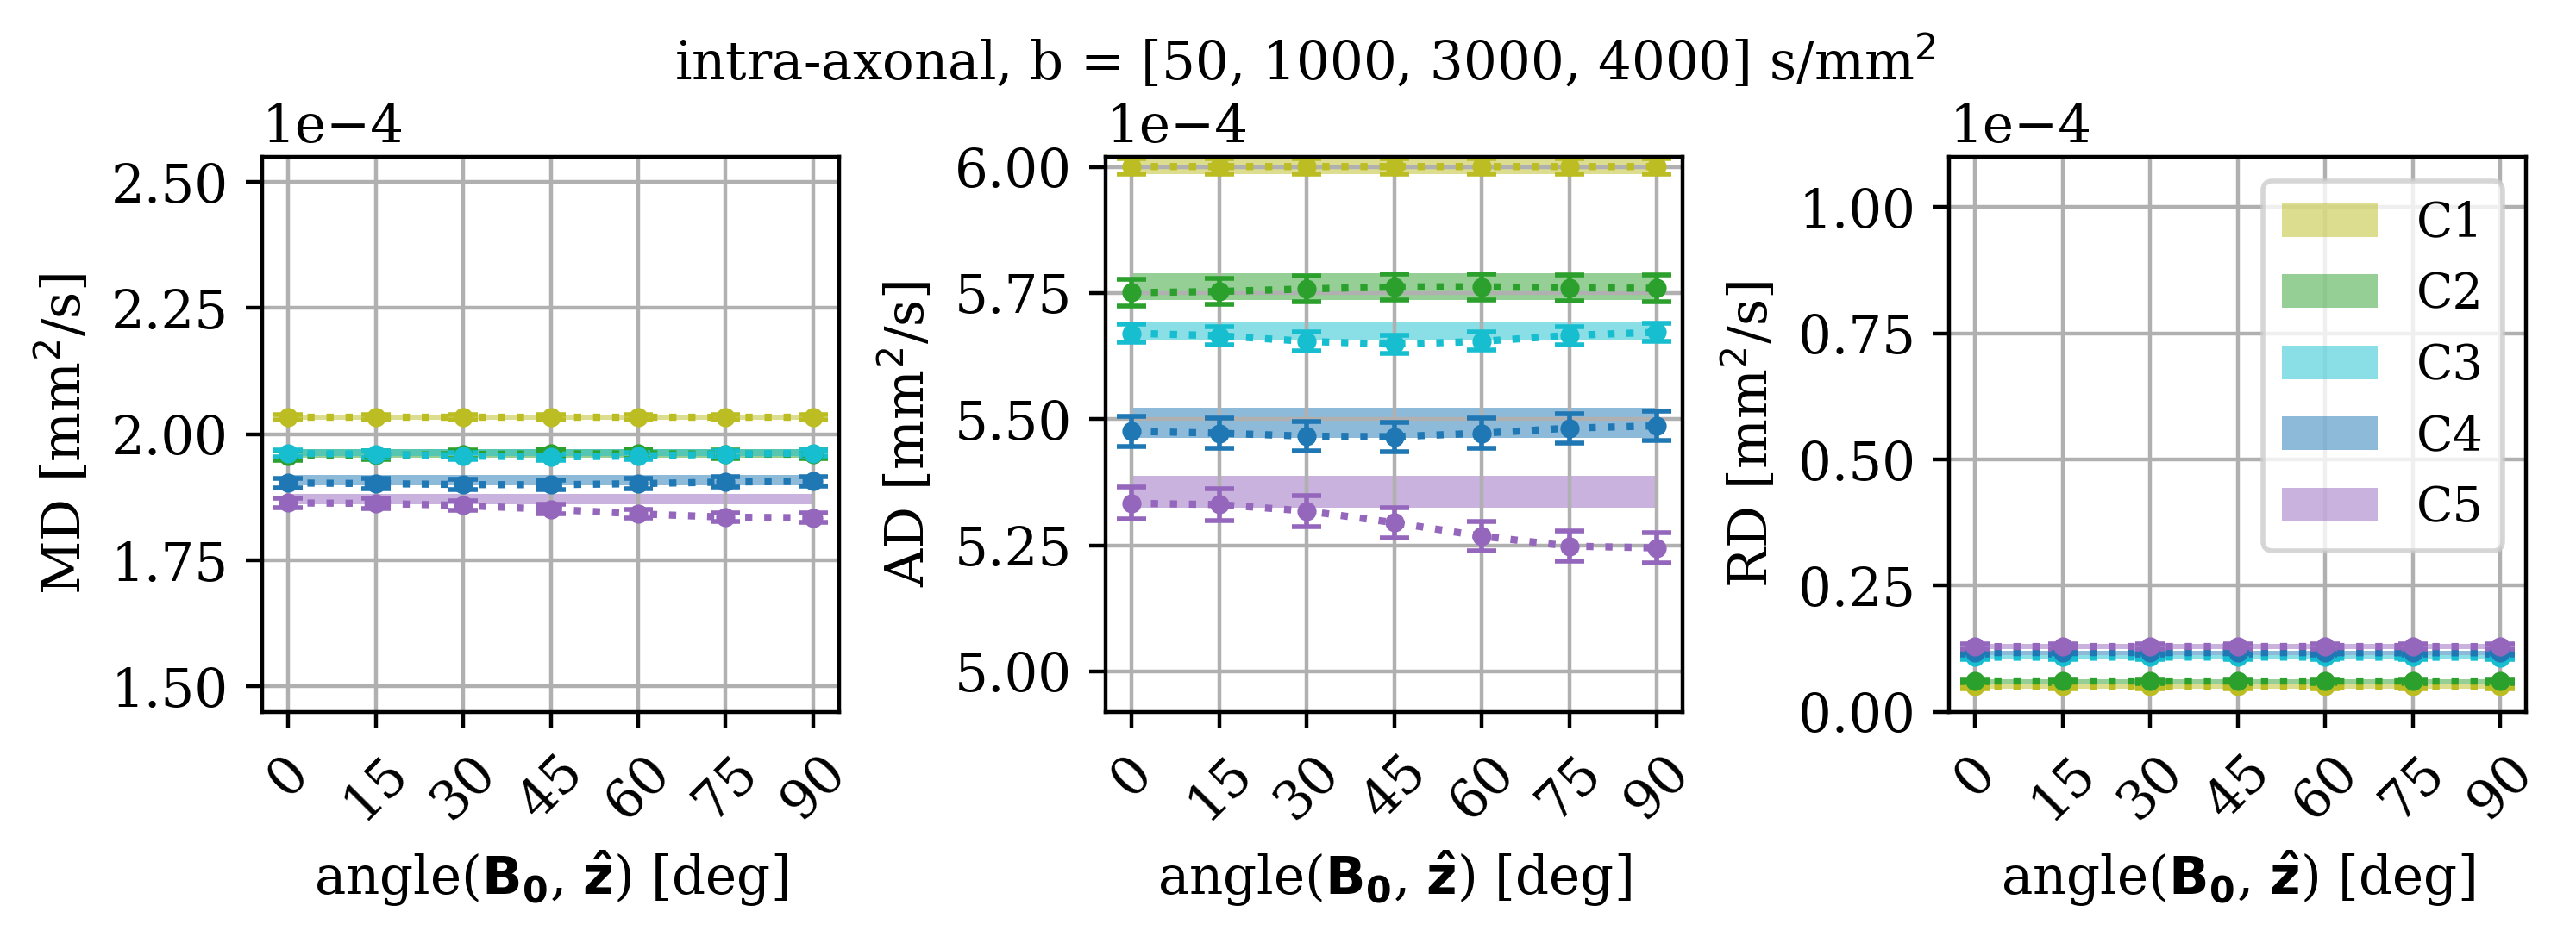

In [23]:
cmap = plt.cm.get_cmap('gnuplot2')

axs_all = []
figs = []

if 'intra' in per_name_substrate[next(iter(per_name_substrate.keys()))][path_scheme_file].keys():
    fig_intra, ax_intra = plt.subplots(1, 3, figsize=figsize_ADC_3x1)
    axs_all.append(ax_intra)
    figs.append(fig_intra)
    fig_intra.suptitle('intra-axonal'+f', b = {bs_oi} s/mm$^2$', y=0.9)

if 'extra' in per_name_substrate[next(iter(per_name_substrate.keys()))][path_scheme_file].keys():
    fig_extra, ax_extra = plt.subplots(1, 3, figsize=figsize_ADC_3x1)
    axs_all.append(ax_extra)
    figs.append(fig_extra)
    fig_extra.suptitle('extra-axonal', y=0.9)

if 'intra+extra' in per_name_substrate[next(iter(per_name_substrate.keys()))][path_scheme_file].keys():
    fig_intra_extra, ax_intra_extra = plt.subplots(1, 3, figsize=figsize_ADC_3x1)
    axs_all.append(ax_intra_extra)
    figs.append(fig_intra_extra)
    fig_intra_extra.suptitle('intra- and extra-axonal', y=0.9)    

for type_substrate, per_name_substrate in tqdm(tensorfits_per_substrate_type.items()):
    
    print('type_substrate: ', type_substrate)
    
    if len(per_name_substrate.keys()) == 0:
        continue
        
    ADCs = []
    ADCs_para = []
    ADCs_perp = []
    B_z_angles = []
    
    ADCs_nf = []
    ADCs_para_nf = []
    ADCs_perp_nf = []
    
    for idx_substrate, (name_substrate, per_scheme) in enumerate(per_name_substrate.items()):
        
        
        if 'G1' in type_substrate:
            label = 'C1'
        elif 'G3' in type_substrate:
            label = 'C2'
        elif 'G4' in type_substrate:
            label = 'C3'
        elif 'G5' in type_substrate:
            label = 'C4'
        elif 'G6' in type_substrate:
            label = 'C5'
        
        if name_substrate == 'all':
            continue
        
        for scheme, per_compartment in per_scheme.items():
            
            for compartment, per_contribution in per_compartment.items():
                
                if compartment == 'intra':
                    fig = fig_intra
                    axs = ax_intra
                    marker = marker_intra
                elif compartment == 'extra':
                    fig = fig_extra
                    axs = ax_extra
                    marker = marker_extra
                if compartment == 'intra+extra':
                    fig = fig_intra_extra
                    axs = ax_intra_extra
                    marker = marker_intra_extra
                    
                #### coloring
                if 'helix' in name_substrate:
                    weight_color = float(name_substrate.split('r_helix=')[-1].split('-')[0]) / 8.
                    color = cmap(weight_color)
                else:
                    color = plotting_specs[type_substrate]['color']
        
                #### plot including only_diffusion_gradients
                fit_dt = per_contribution['signals_only_diffusion_gradients']
                
                ADC = np.mean(fit_dt.evals)
                ADCs_nf.append(ADC)
                ADC_para = fit_dt.evals[0][0][0][0]
                ADCs_para_nf.append(ADC_para)
                ADC_perp = np.mean([fit_dt.evals[0][0][0][1], fit_dt.evals[0][0][0][2]])
                ADCs_perp_nf.append(ADC_perp)
            
                label_switch = True
            
                #### plot including susceptibility contributions
                for name_Bfield, fit_dt in per_contribution['signals_all_gradients'].items():
                    
                    if label_switch:
                        if 'helix' in name_substrate:
                            r_helix = name_substrate.split('r_helix=')[-1].split('-')[0]
                            label = 'r$_{helix}$' + f' = {r_helix}'
                        elif 'axon' in name_substrate:
                            label = name_substrate.split('-')[0]
                        label_switch = False
                    else:
                        label = None
                    
                    B_z_angle = int(np.round(np.rad2deg(float(name_Bfield.split('B_z_angle=')[-1].replace('.pt', '')))))
                    B_z_angles.append(B_z_angle)
            
                    ADC = np.mean(fit_dt.evals)
                    ADCs.append(ADC)

                    ADC_para = fit_dt.evals[0][0][0][0]
                    ADCs_para.append(ADC_para)

                    ADC_perp = np.mean([fit_dt.evals[0][0][0][1], fit_dt.evals[0][0][0][2]])            
                    ADCs_perp.append(ADC_perp)
                    
    capsize = 3
    elinewidth = 1
    markeredgewidth = 1
    ls_err = ':'
    marker_err = '.'
    
    n_Bfields = 7
    n_axons = len(ADCs)//7
    
    #### ADCs
    ADCs = np.reshape(ADCs, (n_axons, 7))
    ADCs_mean = np.mean(ADCs, axis=0)
    ADCs_err = np.std(ADCs, axis=0) / np.sqrt(n_axons)

    axs[0].errorbar(B_z_angles[:n_Bfields], ADCs_mean, yerr=ADCs_err, color=color, capsize=capsize, elinewidth=elinewidth, markeredgewidth=markeredgewidth, ls=ls_err, marker=marker_err)
    
    ADCs_mean_nf = np.mean(ADCs_nf, axis=0)
    ADCs_err_nf = np.std(ADCs_nf, axis=0) / np.sqrt(n_axons)
    axs[0].fill_between([0, 90], ADCs_mean_nf-ADCs_err_nf, ADCs_mean_nf+ADCs_err_nf, color=color, 
                        alpha=0.5, ec=None)

    
    #### ADCs_para
    ADCs_para = np.reshape(ADCs_para, (n_axons, 7))
    ADCs_para_mean = np.mean(ADCs_para, axis=0)
    ADCs_para_err = np.std(ADCs_para, axis=0) / np.sqrt(n_axons)

    axs[1].errorbar(B_z_angles[:n_Bfields], ADCs_para_mean, yerr=ADCs_para_err, color=color, capsize=capsize, elinewidth=elinewidth, markeredgewidth=markeredgewidth, ls=ls_err, marker=marker_err)
    
    ADCs_para_mean_nf = np.mean(ADCs_para_nf, axis=0)
    ADCs_para_err_nf = np.std(ADCs_para_nf, axis=0) / np.sqrt(n_axons)
    axs[1].fill_between([0, 90], ADCs_para_mean_nf-ADCs_para_err_nf, ADCs_para_mean_nf+ADCs_para_err_nf, color=color, 
                        alpha=0.5, ec=None)
    
    #### ADCs_perp
    ADCs_perp = np.reshape(ADCs_perp, (n_axons, 7))
    ADCs_perp_mean = np.mean(ADCs_perp, axis=0)
    ADCs_perp_err = np.std(ADCs_perp, axis=0) / np.sqrt(n_axons)

    axs[2].errorbar(B_z_angles[:n_Bfields], ADCs_perp_mean, yerr=ADCs_perp_err, color=color, capsize=capsize, elinewidth=elinewidth, markeredgewidth=markeredgewidth, ls=ls_err, marker=marker_err)
    
    ADCs_perp_mean_nf = np.mean(ADCs_perp_nf, axis=0)
    ADCs_perp_err_nf = np.std(ADCs_perp_nf, axis=0) / np.sqrt(n_axons)
    axs[2].fill_between([0, 90], ADCs_perp_mean_nf-ADCs_perp_err_nf, ADCs_perp_mean_nf+ADCs_perp_err_nf, color=color, 
                        alpha=0.5, ec=None, 
                        label=label
                       )

    #### table
    # # MD
    # print('%.2f \pm %.2f' %(ADCs_mean_nf*1e4, ADCs_err_nf*1e4))
    # idx_max = np.argmax(ADCs_mean)
    # idx_min = np.argmin(ADCs_mean)
    # print('min', B_z_angles[idx_min])
    # print('%.2f \pm %.2f' %(ADCs_mean[idx_min]*1e4, ADCs_err[idx_min]*1e4))
    # print('max', B_z_angles[idx_max])
    # print('%.2f \pm %.2f' %(ADCs_mean[idx_max]*1e4, ADCs_err[idx_max]*1e4))
    
    # # AD
    # print('%.2f \pm %.2f' %(ADCs_para_mean_nf*1e4, ADCs_para_err_nf*1e4))
    # idx_max = np.argmax(ADCs_para_mean)
    # idx_min = np.argmin(ADCs_para_mean)
    # print('min', B_z_angles[idx_min])
    # print('%.2f \pm %.2f' %(ADCs_para_mean[idx_min]*1e4, ADCs_para_err[idx_min]*1e4))
    # print('max', B_z_angles[idx_max])
    # print('%.2f \pm %.2f' %(ADCs_para_mean[idx_max]*1e4, ADCs_para_err[idx_max]*1e4))

    # RD
    print('%.2f \pm %.2f' %(ADCs_perp_mean_nf*1e4, ADCs_perp_err_nf*1e4))
    idx_max = np.argmax(ADCs_perp_mean)
    idx_min = np.argmin(ADCs_perp_mean)
    print('min', B_z_angles[idx_min])
    print('%.2f \pm %.2f' %(ADCs_perp_mean[idx_min]*1e4, ADCs_perp_err[idx_min]*1e4))
    print('max', B_z_angles[idx_max])
    print('%.2f \pm %.2f' %(ADCs_perp_mean[idx_max]*1e4, ADCs_perp_err[idx_max]*1e4))
    
    #### fix legend
    try:
        _handles, _labels = ax_extra[2].get_legend_handles_labels()
        mask_legend = np.argsort(_labels)
        ax_extra[2].legend(np.array(_handles)[mask_legend], np.array(_labels)[mask_legend], 
                           loc='lower right', ncol=1, fontsize=10)
    except:
        _handles, _labels = ax_intra[2].get_legend_handles_labels()
        mask_legend = np.argsort(_labels)
        ax_intra[2].legend(np.array(_handles)[mask_legend], np.array(_labels)[mask_legend], 
                           loc='upper right', ncol=1, fontsize=10)

for axs in axs_all:

    axs[0].set_ylim(1.45e-4, 2.55e-4)     
    if bs_oi == [50, 1000, 3000, 4000]:
        axs[1].set_ylim(4.92e-4, 6.02e-4)
        tag_fig = ''
    elif bs_oi == [4000, 8000, 12000]:
        axs[1].set_ylim(4.82e-4, 5.92e-4)
        tag_fig = 'b'
    else:
        axs[1].set_ylim(4.92e-4, 6.02e-4)
        tag_fig = 'b'
    axs[2].set_ylim(0.00e-4, 1.10e-4)

    axs[0].set_ylabel('MD [mm$^2$/s]')
    axs[1].set_ylabel('AD [mm$^2$/s]')
    axs[2].set_ylabel('RD [mm$^2$/s]')

    for ax in axs:

        ax.grid(True)
        ax.set_xticks(np.arange(0, 91, 15))
        ax.set_xticklabels(np.arange(0, 91, 15), rotation=45)
        ax.set_xlabel(r'angle($\mathbf{B_0}$, $\mathbf{\hat{z}}$) [deg]')
        ax.ticklabel_format(axis='y', style='sci', scilimits=(-4,-4))

for fig in figs:

    fig.tight_layout()

path_figure = path_figures + f'/orientation_dependencies/XNH-bs_oi={bs_oi}' + tag_fig
plt.savefig(path_figure, dpi=400)
# plt.show()